In [1]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

# Data Ingestion

First, let us import and briefly summarize the data.

In [2]:
PATH_TO_DATA = "../data/raw_data.csv"
raw_df = pd.read_csv(PATH_TO_DATA)

# Output meta data
print("Length: {}".format(len(raw_df)))
print("Columns: {}".format(raw_df.columns.values))
print("# of Authors: {}".format(len(raw_df["author"].unique())))
print("# of Schools: {}".format(len(raw_df["school"].unique())))

Length: 360808
Columns: ['title' 'author' 'school' 'sentence_spacy' 'sentence_str'
 'original_publication_date' 'corpus_edition_date' 'sentence_length'
 'sentence_lowered' 'tokenized_txt' 'lemmatized_str']
# of Authors: 36
# of Schools: 13


# Preprocessing

Let us consider a subset of the data containing the columns: title, author, school, original_publication_date, corpus_edition_date, sentence_str, tokenized_txt.

We should omit columns such as lemmatized_str. Instead, we should remove stop words and lemmetized the sentences ourselves to ensure data integrity.

In [3]:
relevant_cols = ["title", "author", "school",
                 "original_publication_date", "corpus_edition_date",
                 "sentence_str", "tokenized_txt"]

df = raw_df.loc[:, relevant_cols].copy(deep=True)

Let's add the following features. First, let us remove stop words and lemmatize
the tokenized sentences. Then, we can represent the lemmatized sentences as
count vectors relative to all the words in the data.

In [4]:
import ast
from lib.build_features import get_clean_sentence

df["lemmatized_str"] = df["tokenized_txt"].apply(
    lambda row: get_clean_sentence(ast.literal_eval(row))
)
df["lemmatized_str_len"] = df["lemmatized_str"].apply(
    lambda row: len(row.split(" "))
)

# Visualizations

Let's explore the data to visualize and find interesting trends/patterns before.

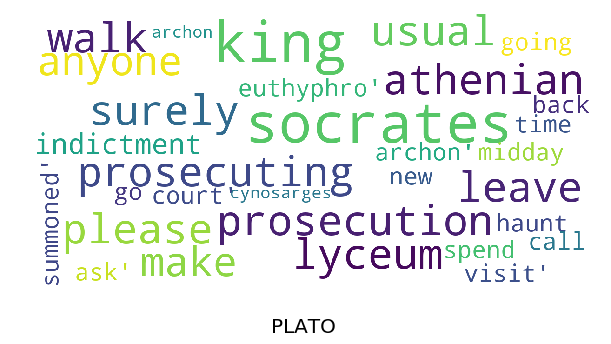

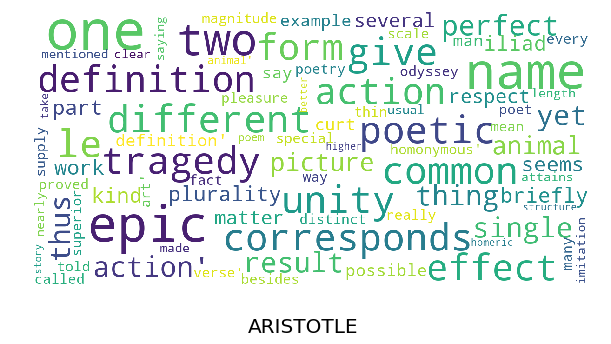

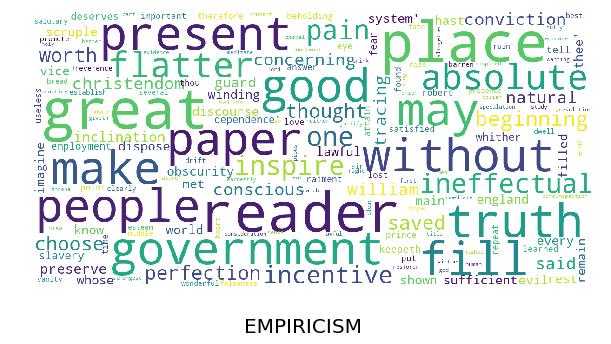

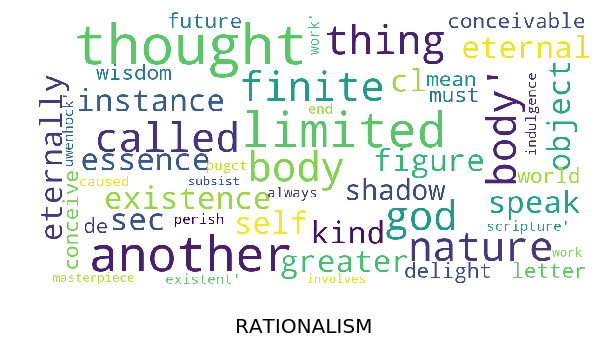

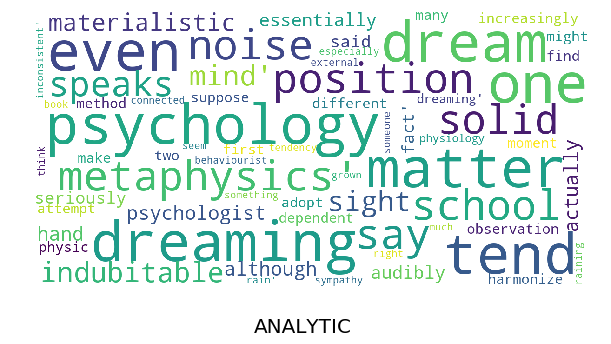

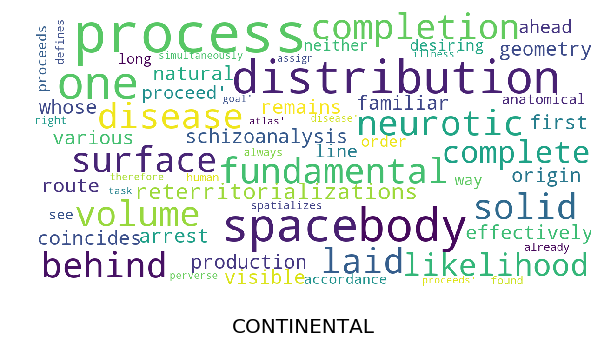

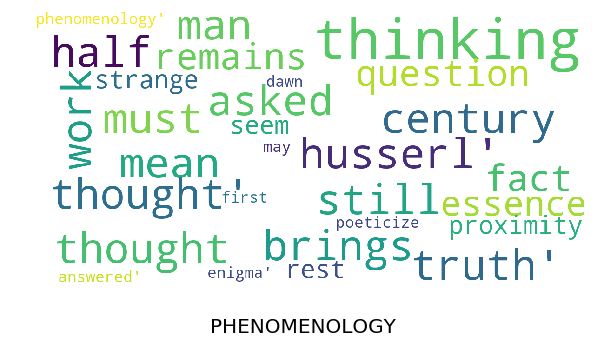

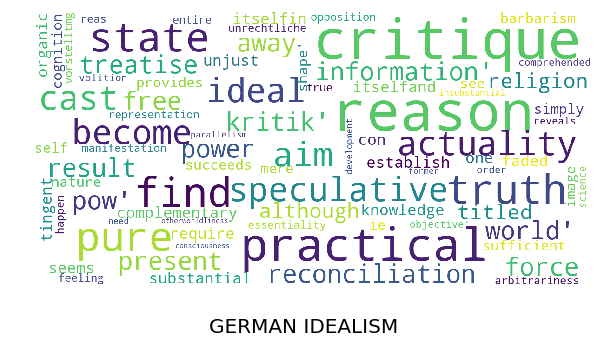

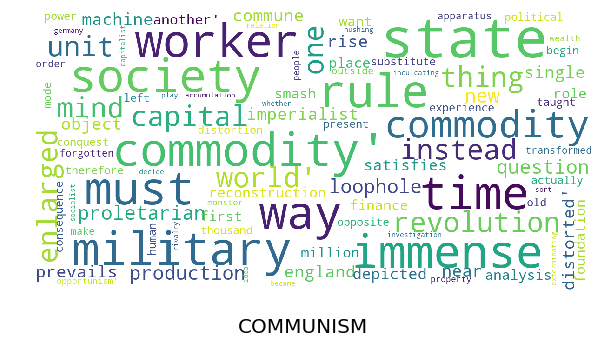

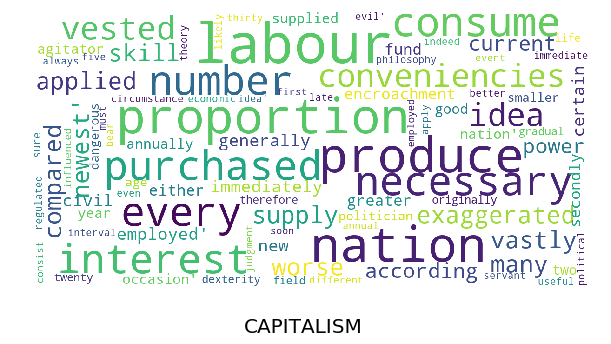

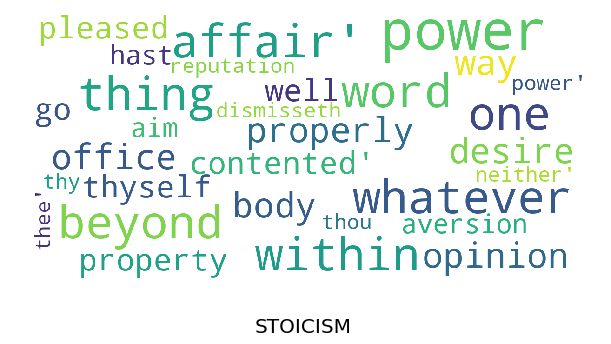

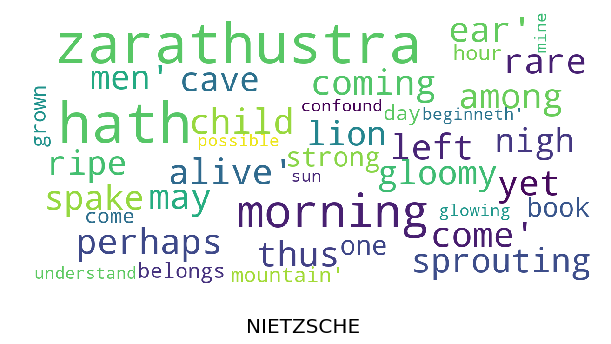

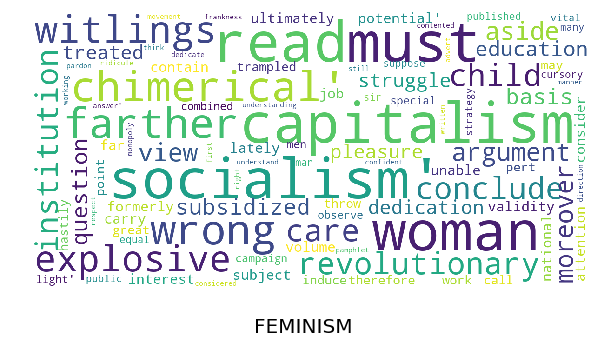

In [5]:
from lib.visualizations import display_wordcloud

schools = df["school"].unique()
for school in schools:
    title = school.replace("_", " ").upper()
    display_wordcloud(
        df.loc[df["school"] == school, ["lemmatized_str"]].values,
        title,
        "../figs/wordcloud-{}.png".format(school)
    )

The results of the wordcloud clearly display the differences in thought and
writing between each philosophical school. For example, the analytic school
focuses on psychology and dreams but the capitalists tend to focus on ideas
such as labour and nation. Moreover, we also observe that older schools
such as the Plato school frequently use antiquated terms such as lyceum and
cynosarges which do not appear in the writing of the newer schools.

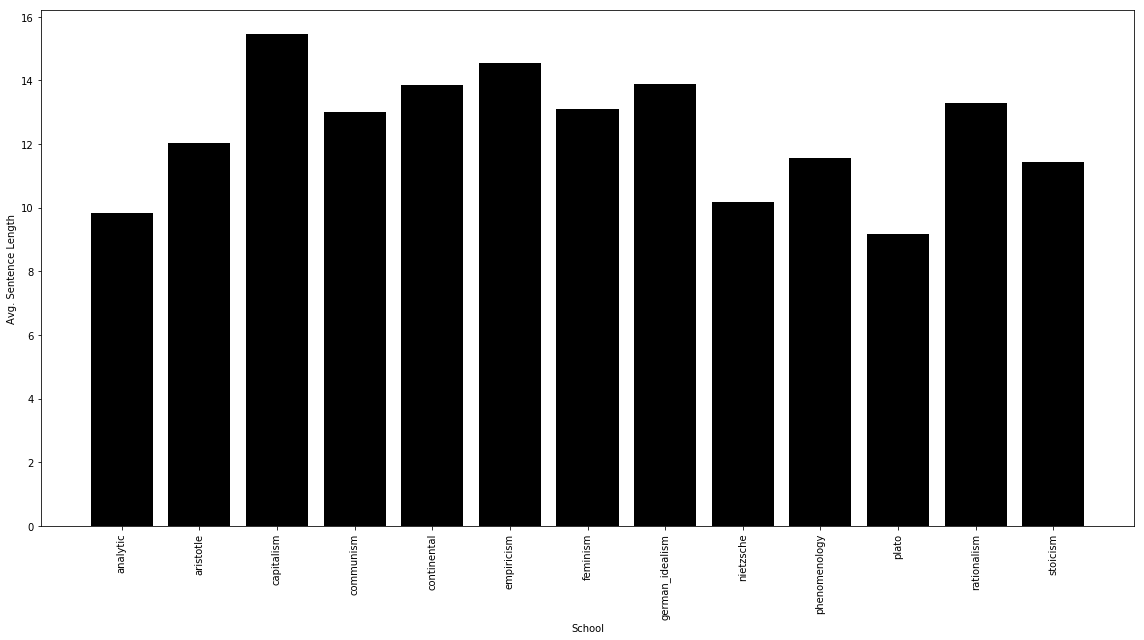

In [6]:
avg_sentence_lengths = df.groupby("school")["lemmatized_str_len"].mean()

fig, axs = plt.subplots(figsize=(16, 9))

axs.bar(avg_sentence_lengths.index, avg_sentence_lengths, color="k")

axs.set_xlabel("School")
axs.set_ylabel("Avg. Sentence Length")
plt.xticks(rotation=90)
plt.tight_layout()

fig.savefig("../figs/barplot-sentence-len.png",  bbox_inches="tight")
plt.show()

Note the disparity in average sentence lengths between various schools.
Capitalists tend to use sentences with almost 16 words on average whereas Plato
writes sentences with roughly half as many words.

# Analysis

## Question: Are the schools truly distinct?


We use a KMeans clustering approach to find the optimal number of clusters
needed to represent the vectorized data. If the number exceeds the number of schools,
then clearly some schools need to be further subdivided. Otherwise, if the number
is strictly less than the number of schools, then there must exist some
redundancies between some schools.

In [7]:
from lib.build_features import get_vectorized_sentences
from sklearn.cluster import MiniBatchKMeans

vectorized_sentences = get_vectorized_sentences(df["lemmatized_str"].values)
lst_inertia = []
for k in range(1, 20):
    model = MiniBatchKMeans(n_clusters=k,
                            random_state=0,
                            batch_size=2048,
                            max_iter=25)
    model.fit(vectorized_sentences)
    lst_inertia.append(model.inertia_)

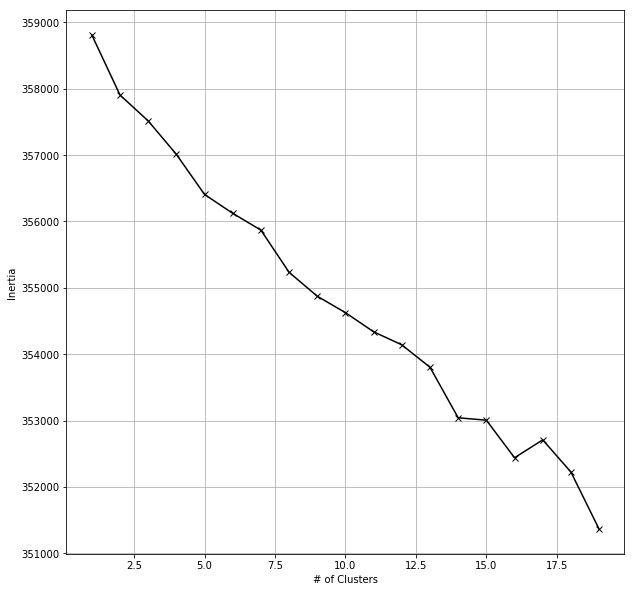

In [8]:
# Plot elbow chart of findings
fig = plt.figure(1, figsize=(10, 10))
plt.plot(list(range(1, len(lst_inertia) + 1)),
             lst_inertia,
             "kx-")

plt.xlabel("# of Clusters")
plt.ylabel("Inertia")
plt.grid()

plt.savefig("../figs/elbow-chart-school.png", bbox_inches="tight")
plt.show()

From the elbow chart, we can clearly see that the inflection point is $k=13$,
implying that $13$ is the optimal number of clusters needed to represent the
sentences. Additionally, recall that the data consists of exactly $13$ schools,
implying that the schools do distinctly characterize the problem.

## Question: Can we predict which author says what?

Here, we are interested in discovering whether authors are predictable. That is,
given an arbitrary sentence from the data, can we accurately predict which
philosopher wrote it?

We build an SVM model over the vectorized feature space with authors as the
target response variable. We chose SVM as our model, because SVM scales well
with linear/non-linear features, and we didn't have a robust understanding of the
underlying feature space.
First, we use an ordinal encoding routine to map each author to an integer value $[1, 37]$.
Then, we split the data, training on 80% of the rows and testing on the remaining 20%.

Note that the model training as well as prediction are done outside this notebook
in '..lib/run_classification_model.py' as the process is very computationally
intensive because the feature space is very rich. Instead, we write
our train/test splits, trained model and predicted values to disk under
'../output/'.

In the next code block, we read the data from disk and report the training
accuracy.

In [9]:
import joblib
from sklearn.metrics import accuracy_score

# Read test data
y_test = joblib.load("../output/train_test_data.dat")["y_test"]
y_pred = joblib.load("../output/y_predicted.dat")["y_pred"]

print("Model Accuracy: {:.2f} %".format(accuracy_score(y_test, y_pred) * 100))

Model Accuracy: 63.95 %


Note that the model correctly finds the authors of $63.95\%$ of sentences.
Although this value is far from great, it is significantly better than randomly
guessing as we have $36$ total authors. But more so, the results imply that
the vectorized feature space alone is inadequate to characterize the words
of a philosopher.

# Conclusion

In this post, we consider clustering and classification problems in NLP to better
understand a corpus of philosophy texts.

To make more accurate future inferences about the data, we should consider the
following revisions. First, we should consider a dimensionality reduction
procedure such as PCA on the vectorized feature space to reduce the
threat of collinearity/overfitting and to reduce our computational burden.
Second, we should spend more time tuning hyperparameters and attempting
the problem on different models to find the model that best approximates our
data.